# Lesson 7: Linear Regression

Fit a linear model to the Leinhardt dataset to find the corrilation between country income and infant mortatlity

This follows lessons here:
 - https://www.coursera.org/learn/mcmc-bayesian-statistics/lecture/z1Aap/setup-in-r
 - https://www.coursera.org/learn/mcmc-bayesian-statistics/lecture/fZngw/jags-model-linear-regression
 - https://www.coursera.org/learn/mcmc-bayesian-statistics/lecture/pAJNW/model-checking

In [1]:
# Download the data from here: 
# https://cran.r-project.org/web/packages/carData/index.html

# read in R data files
# https://github.com/ofajardo/pyreadr
import pyreadr

result = pyreadr.read_r('./data/Leinhardt.rda')
df = result['Leinhardt']
df.dropna(inplace=True)

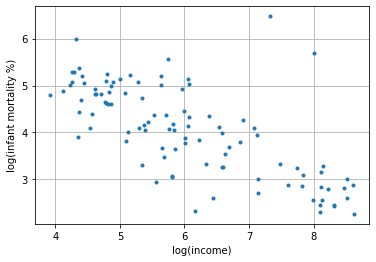

In [2]:
log_infant = np.log(df.infant.values)
log_income = np.log(df.income.values)
plt.plot(log_income, log_infant, '.')
plt.xlabel('log(income)')
plt.ylabel('log(infant mortality %)')

plt.grid(b='both', which='both');

## Modeling

### Linear model

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
lmod = LinearRegression().fit(log_infant.reshape(-1, 1), log_income.reshape(-1, 1))

In [5]:
r_sqd = lmod.score(log_infant.reshape(-1, 1), log_income.reshape(-1, 1))

In [6]:
lmod.intercept_

array([10.01518246])

In [7]:
lmod.coef_

array([[-0.98110443]])

In [8]:
r_sqd

0.50212361972335

### Baysean Monte Carlo

In [9]:
from jax import random
import jax.numpy as np  # We need the CUDA mirror of numpy (even if we're on a CPU)

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)  # Run mcmc in parallel
numpyro.enable_validation()  # Let pyro alert me to potential problems

In [10]:
def mod1_fn(log_income, log_infant):
    # define non-informative priors
    b1 = numpyro.sample('b1', dist.Normal(0, 1e6))
    b2 = numpyro.sample('b2', dist.Normal(0, 1e6))

    std2 = numpyro.sample('std2', dist.InverseGamma(2.5, 2.5 * 10))
    std = np.sqrt(std2)

    # define liklihood
    mu = b1 + b2*log_income
    y = numpyro.sample('y', dist.Normal(mu, std), obs=log_infant)

In [11]:
num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [12]:
kernel = NUTS(mod1_fn)
mod1 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
mod1.run(rng_key, collect_warmup=False, log_income=log_income, log_infant=log_infant, )
mod1.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b1      7.15      0.44      7.15      6.42      7.85   4563.30      1.00
        b2     -0.51      0.07     -0.51     -0.63     -0.40   4580.29      1.00
      std2      0.95      0.13      0.94      0.73      1.16   6255.94      1.00

Number of divergences: 0


In [13]:
samples_1 = mod1.get_samples()

In [14]:
mod1_b1 = samples_1['b1'].reshape(3, -1)
mod1_b2 = samples_1['b2'].reshape(3, -1)
mod1_std2 = samples_1['std2'].reshape(3, -1)

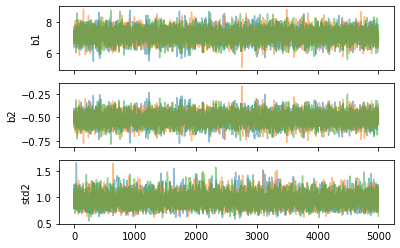

In [15]:
fig, axs = plt.subplots(3, 1, sharex=True)
[axs[0].plot(chain, alpha=.5) for chain in mod1_b1]
axs[0].set_ylabel('b1')
[axs[1].plot(chain, alpha=.5) for chain in mod1_b2]
axs[1].set_ylabel('b2')
[axs[2].plot(chain, alpha=.5) for chain in mod1_std2]
axs[2].set_ylabel('std2');

## Convergence

In [16]:
diag.gelman_rubin(mod1_b1)

1.0001884

In [17]:
diag.gelman_rubin(mod1_b2)

1.0001829

In [18]:
diag.gelman_rubin(mod1_std2)

1.0001044

### Auto Correlation

In [19]:
lag_idx = [0, 1, 5, 10, 50]

In [20]:
diag.autocorrelation(mod1_b1, axis=1)[:, lag_idx]

array([[ 1.00000000e+00,  4.91611880e-01,  5.76008523e-02,
         6.19998225e-04,  1.37903767e-02],
       [ 1.00000000e+00,  5.19166369e-01,  2.34235932e-02,
        -1.31431015e-02, -4.45653492e-02],
       [ 1.00000000e+00,  5.54168135e-01,  4.53391732e-02,
        -1.16576768e-02, -5.35732124e-03]])

In [21]:
diag.autocorrelation(mod1_b2, axis=1)[:, lag_idx]

array([[ 1.        ,  0.49183176,  0.05787461,  0.00667721,  0.01946086],
       [ 1.        ,  0.51600162,  0.02232307, -0.01927623, -0.04279028],
       [ 1.        ,  0.55391024,  0.04161856, -0.01011605, -0.00255354]])

In [22]:
diag.autocorrelation(mod1_std2, axis=1)[:, lag_idx]

array([[ 1.        ,  0.45362977,  0.03945353, -0.00852252, -0.01116697],
       [ 1.        ,  0.39714965, -0.01105182, -0.00485601, -0.01181986],
       [ 1.        ,  0.33388487,  0.02349229, -0.02146206, -0.02071139]])

### Effective sample

Effective sample size appears to be much higher than in the lesson. Maybe this is due to using the NUTS Kernel - a more effective sampling method?

In [23]:
# import original numpy
# We need to do this because `effective_sample_size` modifies the array, and a Jax array is immutable
import numpy as onp

In [24]:
diag.effective_sample_size(onp.array(mod1_b1))

4563.299240263115

In [25]:
diag.effective_sample_size(onp.array(mod1_b2))

4580.288774933511

In [26]:
diag.effective_sample_size(onp.array(mod1_std2))

6255.943935951417

## Residuales

In [27]:
b1_mean = samples_1['b1'].mean()
b2_mean = samples_1['b2'].mean()
sig = samples_1['std2'].mean()

In [28]:
y_hat = b1_mean + b2_mean * log_income

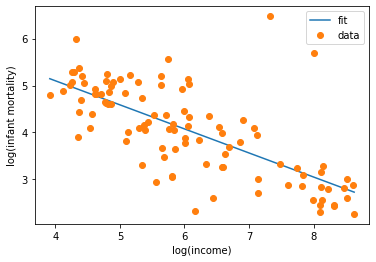

In [29]:
idx_order = np.argsort(log_income)  # needed for plotting the fit line
plt.plot(log_income[idx_order], y_hat[idx_order], label='fit')
plt.plot(log_income, log_infant, 'o', label='data')
plt.xlabel('log(income)')
plt.ylabel('log(infant mortality)')
plt.legend();

In [30]:
residules = log_infant - y_hat

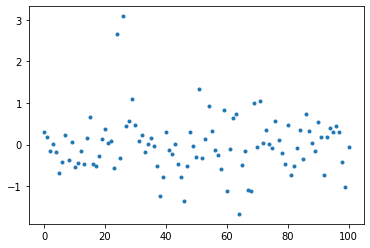

In [31]:
plt.plot(residules, '.');

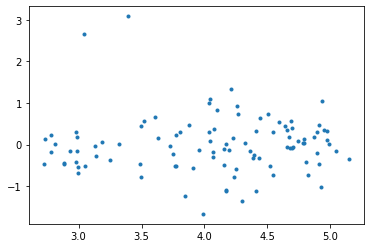

In [32]:
plt.plot(y_hat, residules, '.');

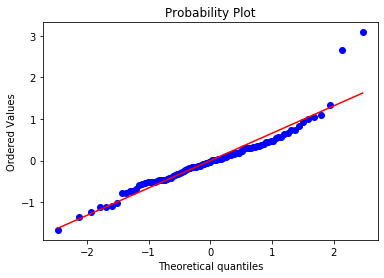

In [33]:
import scipy.stats as stats

stats.probplot(residules, dist="norm", plot=plt);

## Improving the model

### Include another parameter

In [34]:
def mod2_fn(log_income, log_infant, is_oil):
    # define non-informative priors
    b1 = numpyro.sample('b1', dist.Normal(0, 1e6))
    b2 = numpyro.sample('b2', dist.Normal(0, 1e6))
    b3 = numpyro.sample('b3', dist.Normal(0, 1e6))

    std2 = numpyro.sample('std2', dist.InverseGamma(2.5, 2.5 * 10))
    std = np.sqrt(std2)

    # define liklihood
    mu = b1 + b2*log_income + b3*is_oil
    y = numpyro.sample('y', dist.Normal(mu, std), obs=log_infant)

In [35]:
is_oil = np.array(df.oil.values == 'yes', dtype=np.float32) 

In [36]:
kernel = NUTS(mod2_fn)
mod2 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
mod2.run(rng_key, collect_warmup=False, log_income=log_income, log_infant=log_infant, is_oil=is_oil)
mod2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b1      7.14      0.44      7.14      6.43      7.88   5801.80      1.00
        b2     -0.52      0.07     -0.52     -0.64     -0.40   5870.01      1.00
        b3      0.79      0.35      0.79      0.22      1.37   9127.63      1.00
      std2      0.91      0.13      0.90      0.70      1.11   9818.83      1.00

Number of divergences: 0


In [37]:
samples_2 = mod2.get_samples()

In [38]:
y_hat = (samples_2['b1'][:, np.newaxis] 
         + samples_2['b2'][:, np.newaxis] * log_income 
         + samples_2['b3'][:, np.newaxis] * is_oil)

In [39]:
y_hat = np.mean(y_hat, axis=0)

In [40]:
residules = log_infant - y_hat

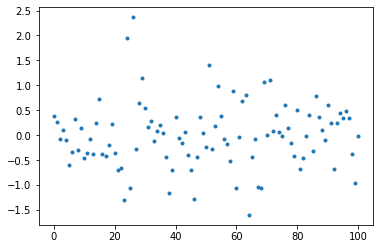

In [41]:
plt.plot(residules, '.');

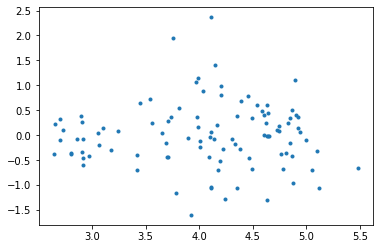

In [42]:
plt.plot(y_hat, residules, '.');

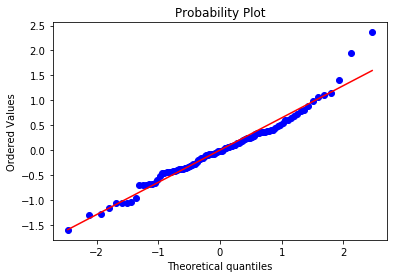

In [43]:
stats.probplot(residules, dist="norm", plot=plt);

### Change the data distribution

This does not appear to do any better?  
More here: https://www.coursera.org/learn/mcmc-bayesian-statistics/discussions/weeks/3/threads/XQJ-1MptEee67g6R1TtyAA

In [44]:
def mod3_fn(log_income, log_infant, is_oil):
    # define non-informative priors
    b1 = numpyro.sample('b1', dist.Normal(0, 1e6))
    b2 = numpyro.sample('b2', dist.Normal(0, 1e6))
    b3 = numpyro.sample('b3', dist.Normal(0, 1e6))

    tau = numpyro.sample('tau', dist.InverseGamma(2.5, 2.5 * 10))    
    df = numpyro.sample('df', dist.Exponential(1))
    
    # define liklihood
    mu = b1 + b2*log_income + b3*is_oil
    y = numpyro.sample('y', dist.StudentT(df, mu, tau), obs=log_infant)

In [45]:
kernel = NUTS(mod3_fn)
mod3 = MCMC(kernel, num_warmup, num_samples, num_chains=3)
mod3.run(rng_key, collect_warmup=False, log_income=log_income, log_infant=log_infant, is_oil=is_oil)
mod3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b1      7.33      0.33      7.33      6.80      7.87   8076.38      1.00
        b2     -0.55      0.05     -0.55     -0.64     -0.46   8157.88      1.00
        b3      0.34      0.33      0.33     -0.17      0.89  10843.27      1.00
        df      5.00      1.53      4.76      2.68      7.34  10771.41      1.00
       tau      0.69      0.06      0.69      0.58      0.79  10324.44      1.00

Number of divergences: 0


In [46]:
samples_3 = mod3.get_samples()
mod3_b1 = samples_3['b1']
mod3_b2 = samples_3['b2']
mod3_b3 = samples_3['b3']

Text(0, 0.5, 'b3')

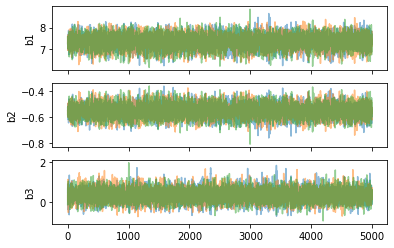

In [47]:
fig, axs = plt.subplots(3, 1, sharex=True)
[axs[0].plot(chain, alpha=.5) for chain in mod3_b1.reshape(3, -1)]
axs[0].set_ylabel('b1')
[axs[1].plot(chain, alpha=.5) for chain in mod3_b2.reshape(3, -1)]
axs[1].set_ylabel('b2')
[axs[2].plot(chain, alpha=.5) for chain in mod3_b3.reshape(3, -1)]
axs[2].set_ylabel('b3')

In [48]:
y_hat = (mod3_b1[:, np.newaxis] + mod3_b2[:, np.newaxis] * log_income + mod3_b3[:, np.newaxis] * is_oil)
y_hat = np.mean(y_hat, axis=0)
residules = log_infant - y_hat

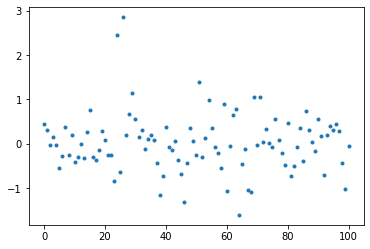

In [49]:
plt.plot(residules, '.');

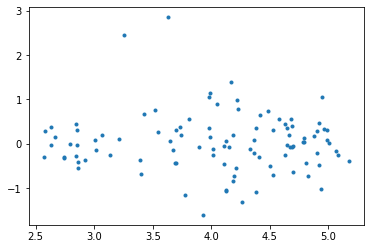

In [50]:
plt.plot(y_hat, residules, '.');

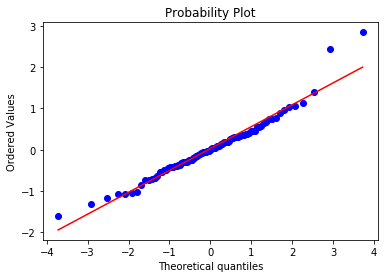

In [75]:
df = onp.array(samples_3['df']).mean()
stats.probplot(residules, dist='t', sparams=(df,), plot=plt);

## Deviance information criterion (DIC)